In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)

In [51]:
config_path = "../configs/task2_2.py"
cfg = LazyConfig.load(config_path)

dataset_to_visualize = "train" # or "val"

cfg.train.batch_size = 32

if dataset_to_visualize == "train":
    # Remove GroundTruthBoxesToAnchors transform
    if cfg.data_train.dataset._target_ == torch.utils.data.ConcatDataset:
        for dataset in cfg.data_train.dataset.datasets:
            print(dataset.transform.transforms)
            dataset.transform.transforms = dataset.transform.transforms[:-1]
    else:
        cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
    dataset = instantiate(cfg.data_train.dataloader)
    gpu_transform = instantiate(cfg.data_train.gpu_transform)
else:
    cfg.data_val.dataloader.collate_fn = utils.batch_collate
    dataset = instantiate(cfg.data_val.dataloader) 
    gpu_transform = instantiate(cfg.data_val.gpu_transform)

# Assumes that the first GPU transform is Normalize
# If it fails, just change the index from 0.
image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)

It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/mariueng
Saving all SSD outputs to: /work/snotra/mariueng/ssd_outputs
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


In [52]:
# Get next sample
sample = next(iter(dataset))
sample = gpu_transform(sample)

In [53]:
# instantiate transformers
rsc = cfg.data_train.dataset.transform.transforms[0]['_target_']()
tt = cfg.data_train.dataset.transform.transforms[1]['_target_']()
re = cfg.data_train.dataset.transform.transforms[2]['_target_']((128, 1024))
# gtbta = cfg.data_train.dataset.transform.transforms[3]['_target_'](, 0.5)
rhf = cfg.data_train.dataset.transform.transforms[4]['_target_']()

In [55]:
print("The first sample in the dataset has the following keys:", sample.keys())
for key, item in sample.items():
    print(
        key, ": shape=", item.shape if hasattr(item, "shape") else "", 
        " dtype=", item.dtype if hasattr(item, "dtype") else type(item), sep="")


The first sample in the dataset has the following keys: dict_keys(['image', 'boxes', 'labels'])
image: shape=torch.Size([32, 3, 128, 1024]) dtype=torch.float32
boxes: shape=torch.Size([32, 49056, 4]) dtype=torch.float32
labels: shape=torch.Size([32, 49056]) dtype=torch.int64


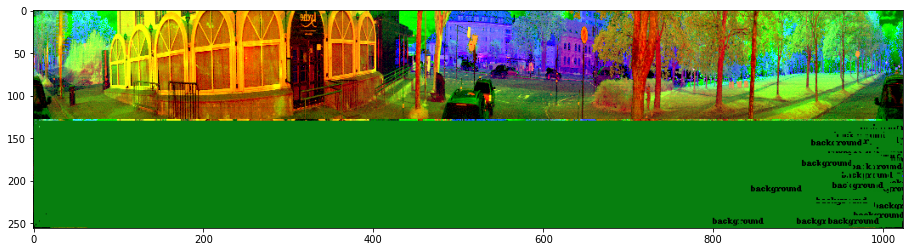

In [49]:
# Convert image to HWC byte
image = (sample["image"] * image_std + image_mean)
image = (image * 255).byte()[0]
im = image.permute(1, 2, 0).cpu().numpy()

# Convert boxes to pixel coordinates
boxes = sample["boxes"][0]
boxes[:, [0, 2]] *= image.shape[-1]  # width
boxes[:, [1, 3]] *= image.shape[-2]  # height

# Draw boxes on image, params: image, boxes with pixel coordinates, label value, label names.
im_with_boxes = draw_boxes(im, boxes.cpu().numpy(), sample["labels"][0].cpu().numpy().tolist(), class_name_map=cfg.label_map)

concat_im = np.concatenate([im, im_with_boxes], axis=0)

#fig, ax = plt.subplot(figsize=(18, 2))
#plt.imshow(im)
fig, ax = plt.subplots(figsize=(36, 4))
ax.imshow(concat_im)
#plt.show()

In [34]:
len(boxes)

49056

In [47]:
sample = rhf(sample)

{'image': tensor([[[[-1.6147, -1.5748, -1.6147,  ..., -1.6147, -1.6147, -1.6147],
           [-1.6014, -1.6147, -0.7775,  ..., -1.6147, -1.6147, -1.6147],
           [-1.5748, -0.8572, -1.6147,  ..., -1.6147, -1.6147, -1.6147],
           ...,
           [-1.6147, -1.6147, -1.6147,  ..., -1.6147, -1.6147, -1.6147],
           [-1.6147, -1.6147, -1.6147,  ..., -1.6147, -1.6147, -1.6147],
           [-1.6147, -1.6147, -1.6147,  ..., -1.6147, -1.6147, -1.6147]],
 
          [[ 0.3870,  0.4828,  0.5513,  ..., -0.1744, -0.2292, -0.0238],
           [-0.1881,  0.0584,  0.3185,  ..., -0.4209, -0.2429, -0.1333],
           [-0.1196, -0.2018, -0.1196,  ..., -0.2566, -0.1881, -0.0512],
           ...,
           [-1.6669, -1.6532, -1.6669,  ..., -1.6669, -1.6669, -1.6669],
           [-1.6669, -1.6669, -1.5711,  ..., -1.6669, -1.6669, -1.6258],
           [-1.6669, -1.6532, -1.6669,  ..., -1.6669, -1.6258, -1.6669]],
 
          [[-0.7849, -0.7713, -0.7577,  ..., -0.7849, -0.7849, -0.7849],
    